In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
SEED = 42

DATA_PATH = Path("/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz")
RESULT_DIR = Path().absolute().parent / "data" / "profiling"

In [4]:
rng = np.random.default_rng(SEED)

In [5]:
data = np.load(DATA_PATH)
data

NpzFile '/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-1/data/training_set.npz' with keys: images, labels

In [6]:
images: np.ndarray = data["images"]
labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


<Axes: ylabel='Percent'>

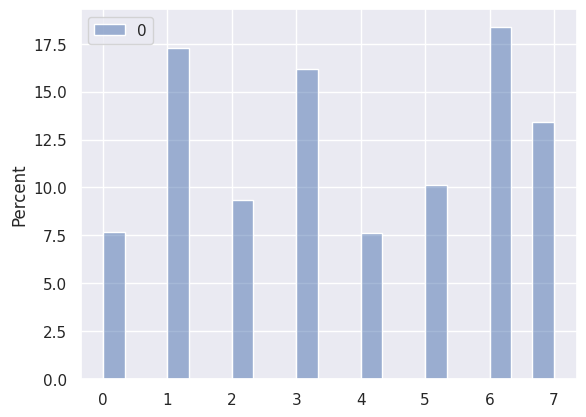

In [7]:
sns.histplot(labels, stat="percent")

In [8]:
number_labels = len(np.unique(labels))
number_labels

8

In [9]:
supports = {label: np.ravel(labels == label) for label in np.unique(labels)}
supports.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [10]:
supports[0].shape

(13759,)

In [11]:
images.shape

(13759, 96, 96, 3)

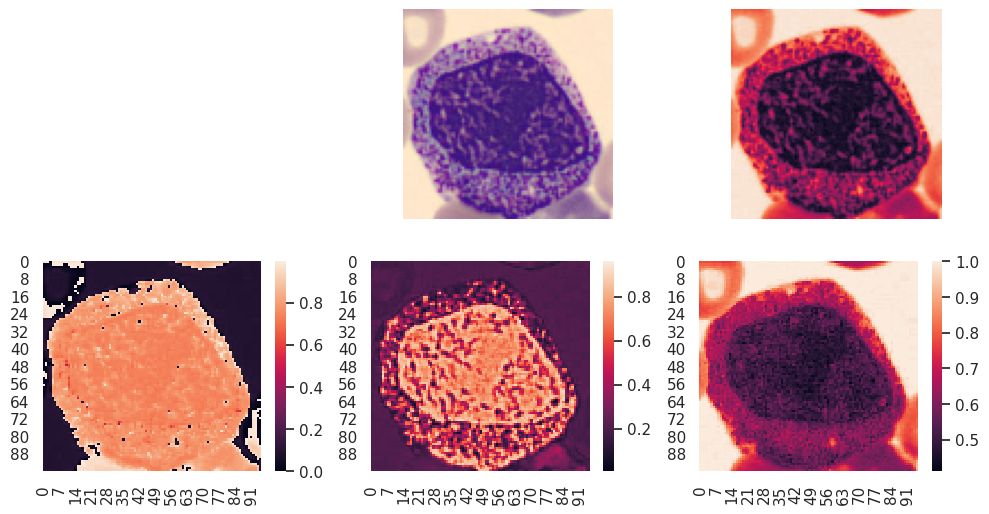

In [12]:
SELECTED_IMAGE = 48

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
for ax in axes[0]:
    ax.set_axis_off()
axes[0][1].imshow(images[SELECTED_IMAGE])
axes[0][2].imshow(images[SELECTED_IMAGE].mean(axis=-1))
for i, ax in enumerate(axes[1]):
    sns.heatmap(
        rgb_to_hsv(images[SELECTED_IMAGE].astype("float") / 255)[:, :, i],
        ax=ax
    )

Plot a random sample of images from each class

We use `rng.choice` on purpose to get different images each time we run the cell so we can see more pictures by executing multiple times.

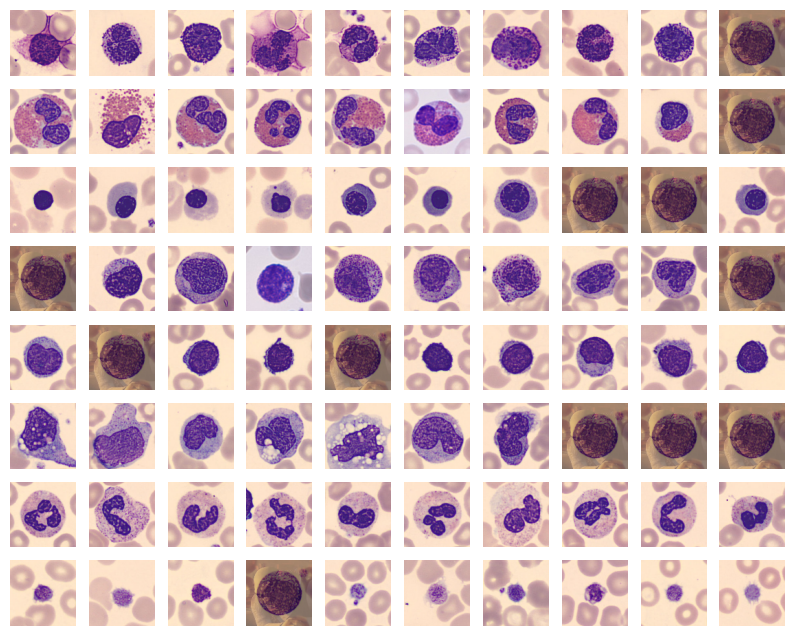

In [13]:
fig, axes = plt.subplots(nrows=number_labels, ncols=10, figsize=(10, 8))
for row_axes, support in zip(axes, supports.values()):
    indices = rng.choice(support.nonzero()[0], size=10, replace=False)
    for ax, i in zip(row_axes, indices):
        ax.set_axis_off()
        ax.imshow(images[i])

Analyse image intensity distributions

<Axes: >

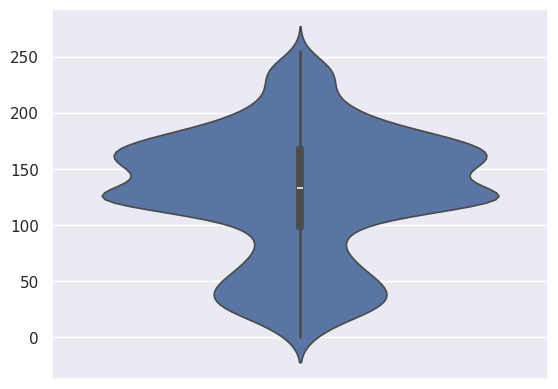

In [22]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))
sns.violinplot(image_means)

### Check for duplicates

<Axes: ylabel='Count'>

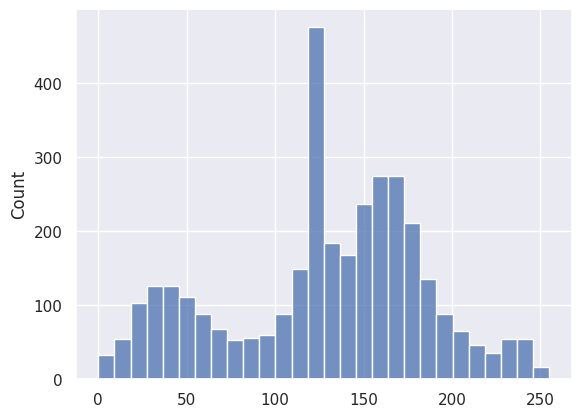

In [23]:
sns.histplot(image_means)

In [24]:
TOLERANCE = 1e-3
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

1

In [25]:
for indices in mean_indices.values():
    print(np.unique(labels[indices]))

[0 1 2 3 5 6 7]


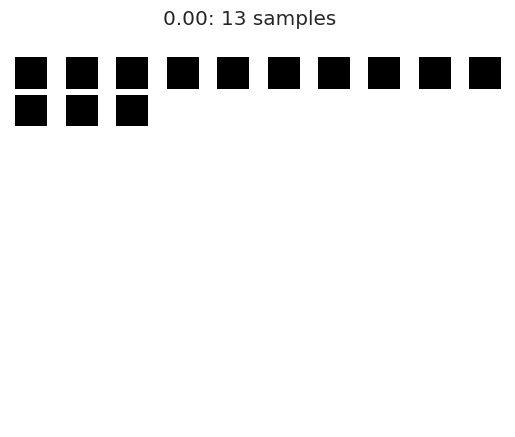

In [26]:
for mean, indices in mean_indices.items():
    # Limit to first 100 samples
    selected_indices = rng.choice(indices, np.min((len(indices), 100)), replace=False)
    fig, axes = plt.subplots(ncols=10, nrows=10)
    fig.suptitle(f"{mean:.2f}: {len(indices)} samples")
    axes = axes.reshape((-1))
    for ax in axes:
        ax.set_axis_off()
    for i, ax in zip(selected_indices, axes):
        ax.imshow(images[i])

In [27]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(13,)

In [28]:
# np.save(RESULT_DIR / "junk_indices", duplicated_indices)

In [29]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(3408,)

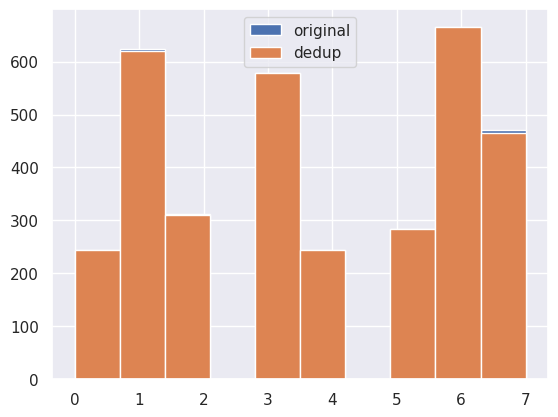

In [31]:
plt.hist(labels, label="original")
plt.hist(labels[original_indices], label="dedup")
plt.legend()

### Check for statistical outliers in the images

In [32]:
dedup_image_means = image_means[original_indices]
dedup_image_means

array([146.07631655, 118.96516927, 170.80519387, ..., 177.66449653,
        28.30088976, 183.18695747])

In [33]:
image_means_quantiles = np.quantile(dedup_image_means, (0.25, 0.5, 0.75))
image_means_quantiles

array([ 99.17759874, 133.78980396, 167.97818106])

In [34]:
outlier_factor: np.ndarray = np.abs(dedup_image_means - image_means_quantiles[1])
outlier: np.ndarray = outlier_factor > 1.5 * (
    image_means_quantiles[2] - image_means_quantiles[0]
)
outlier.sum()

303

In [35]:
outlier.nonzero()[0].shape

(303,)

In [36]:
outlier_indices = outlier.nonzero()[0]
outlier_indices

array([  26,   31,   35,   43,   46,   51,   58,   63,   99,  105,  125,
        136,  156,  165,  170,  209,  264,  271,  280,  284,  296,  298,
        302,  313,  319,  321,  341,  344,  354,  360,  388,  411,  418,
        445,  448,  450,  454,  475,  487,  494,  506,  532,  549,  553,
        554,  562,  573,  579,  594,  603,  604,  620,  650,  659,  661,
        663,  671,  673,  680,  695,  705,  706,  724,  736,  739,  749,
        768,  778,  781,  786,  794,  796,  801,  806,  808,  818,  821,
        852,  855,  860,  884,  889,  894,  906,  914,  920,  926,  944,
        954,  975, 1002, 1009, 1030, 1041, 1064, 1075, 1092, 1097, 1125,
       1130, 1153, 1163, 1166, 1188, 1192, 1194, 1207, 1216, 1232, 1287,
       1300, 1304, 1311, 1320, 1338, 1348, 1401, 1405, 1422, 1438, 1445,
       1446, 1447, 1455, 1458, 1463, 1469, 1474, 1478, 1488, 1493, 1495,
       1502, 1504, 1511, 1513, 1519, 1547, 1567, 1577, 1587, 1590, 1592,
       1594, 1595, 1604, 1606, 1608, 1611, 1624, 16

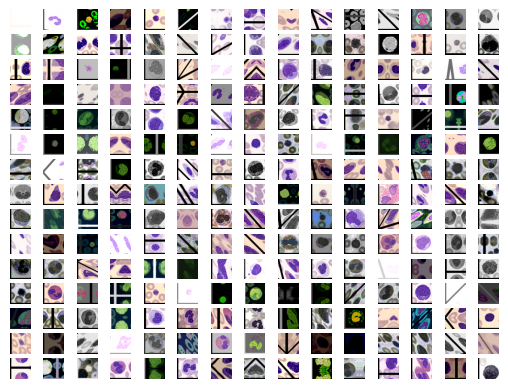

In [37]:
fig, axes = plt.subplots(nrows=15, ncols=15)
axes = axes.reshape((-1))
for ax in axes:
    ax.set_axis_off()
for i, ax in zip(rng.permutation(outlier_indices), axes):
    ax.imshow(images[i])